# Objectives:
- Investigate the distribution of each cluster's unique contributors who contribute to the cluster once/multiple times.

# Takeaways:

- We can check whether a cluster is "actally clumpy according to reference data" by checking whether at least two reference spots are within the area spanned by the cluster’s member annotations.
- Stratifying clusters by fraction of contributors who have contributed once vs. multiple times seems to be a good way to separate clusters that are actually clumpy according to reference data from clusters that are not actually clumpy. Below a certain threshold, clusters tend to be actually clumpy and these actual-clumpy-clusters can be teased apart. Above this threshold, any clusters that are actually clumpy correspond with very close/overlapping spots that really do look like one spot.

# Next steps:
### Declumping
- Automatically find clumpiness threshold (to ID clusters to which many contributors have contributed multiple times).
    - Do k-means and/or Otsu provide good thresholds?
    - Interestingly, 0.8, the threshold I empirically found from playing around with plots when taking a first look at this data, appears from the histograms to be a very good threshold for this dataset.
- Do any of these clumpy clusters show obvious degrees of clumpiness (lots of workers annotate 2x, 3x, etc)? If so, we’d have the k needed to apply partitioning, e.g. k-means, to that clump.
    - Plot a histogram for each cluster with number of contributions from unique who contributes to the cluster.
    - The problem has an layer of complexity exemplifed at (50, 220) on the scatter plot for snr_5_0_density_0.008_spots.png: two centroids were found for three actual spots. These two centroids are considered different clusters.
- Flag areas that need more zoomed-in annotation by detecting regions with a lot of clumpiness

# Details:

To find a good threshold for the number of unique annotators per cluster to separate likely-correct from likely-incorrect clusters, we looked at histograms like the ones in __[this notebook](https://github.com/czbiohub/FISH-annotation/blob/BaseAnnotation/Annotation/density_test_cluster_size_thresholding_and_roc_varying_density.ipynb)__, which we discussed recently, to find separation between clusters which our reference data tells us are correct and clusters which our reference data tells us are incorrect.

Analogously, to find a good threshold for the proportion of contributors to a cluster who only contribute once to that cluster, I am looking at the histograms in this notebook to find separation between clusters which our reference data tells us are actually clumpy and clusters which our reference data tells us are actually not clumpy.

To detect whether a cluster is “actually clumpy according to reference data,” I check whether at least two reference spots are within the area spanned by the cluster’s member annotations. If so, the cluster is actually clumpy according to reference data. These are represented in bright orange on the histograms. Clusters that are not actually clumpy according to reference data are represented in bright blue on the histograms.

I was surprised to detect so many “actually clumpy” clusters to which most or all workers only contributed one annotation. Without obvious separation between bright blue and bright orange on the histograms, I was worried about the goal of thresholding for clumpiness. I made a scatterplot for visualization to accompany each histogram.

I colored the nearest reference spot to each centroid in purple and the second-nearest reference spot in dark pink. I noticed that in many of the actually-clumpy clusters, the associated reference spots are really near each other and often even overlapping. Looking again at the images, I found that I myself would have only picked out one spot where these clusters are. I hypothesized that actually-clumpy clusters further to the right side of the histogram (with more contributing workers contribute just one annotation) represent spots that really look like just one spot. I colored in light green the member annotations of clumpy clusters where all workers annotated just once, and colored in light pink all clumpy clusters where some workers annotated more than once. Sure enough, the associated spots are a lot closer together where member annotations are colored in light green. With real images, if all or almost all workers click only once on something that looks like one spot but is actually multiple spots, it may not be possible to declump this cluster without planar projections along other axes.

# Guide to the scatter plots in this notebook
- Centroids are represented with unfilled circle markers.
    - The centroids of actual non-clumps (with only one reference spot within the area spanned by the cluster’s member annotations) are represented with bright blue unfilled circle markers.
    - The centroids of actual clumps (with at least two reference spots within the area spanned by the cluster’s member annotations) are represented with bright orange unfilled circle markers.
- Annotations of “actually clumpy” clusters are represented with filled circle markers.
    - In some “actually clumpy” clusters, no contributing workers contributed more than one annotation. The member annotations of these clusters are shown as small light filled green circle markers.
    - In other “actually clumpy” clusters, at least one contributing worker contributed more than one annotation. The member annotations of these clusters are shown small light pink filled circle markers.
- Reference annotations are represented with filled circle markers.
    - The reference annotation nearest to the centroid of a clumpy cluster is represented with a dark purple circle marker.
    - The reference annotation nearest to the centroid of a clumpy cluster is represented with a dark pink circle marker.
    - Other reference annotations are represented with light purple filled circle markers.


In [1]:
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from BaseAnnotation import BaseAnnotation
from QuantiusAnnotation import QuantiusAnnotation
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from skimage import filters

%matplotlib inline

worker_marker_size = 8
cluster_marker_size = 40
bigger_window_size = True
img_height = 300
show_correctness = True
correctness_threshold = 4
clustering_params = ['AffinityPropagation', -350]

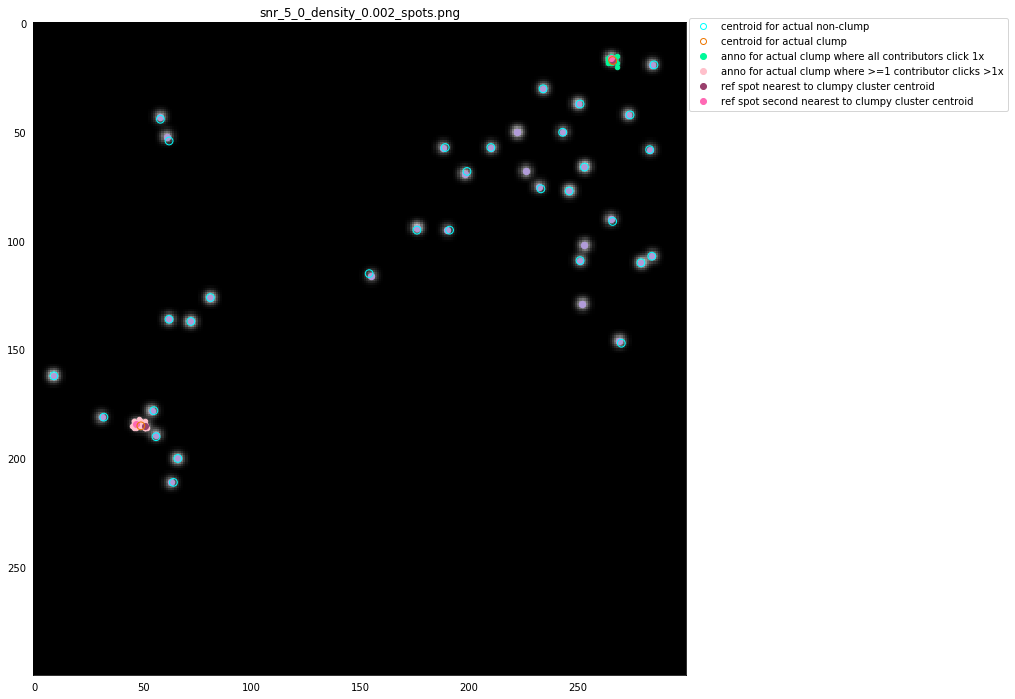

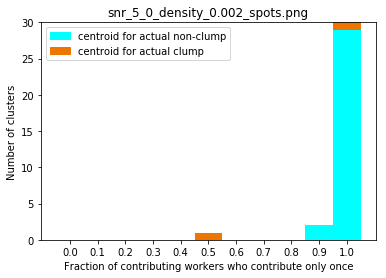

2 actual clumps
31 actual non-clumps


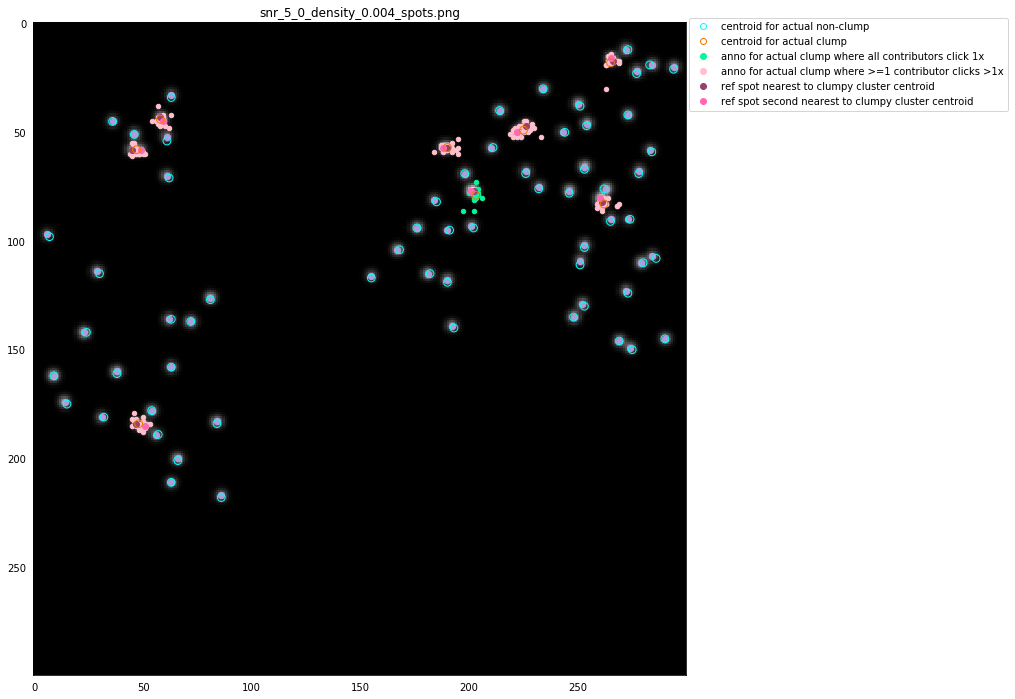

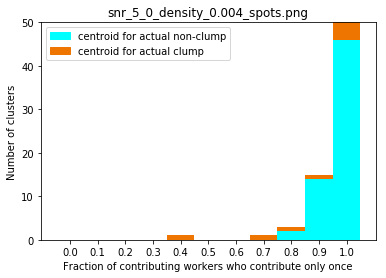

8 actual clumps
62 actual non-clumps


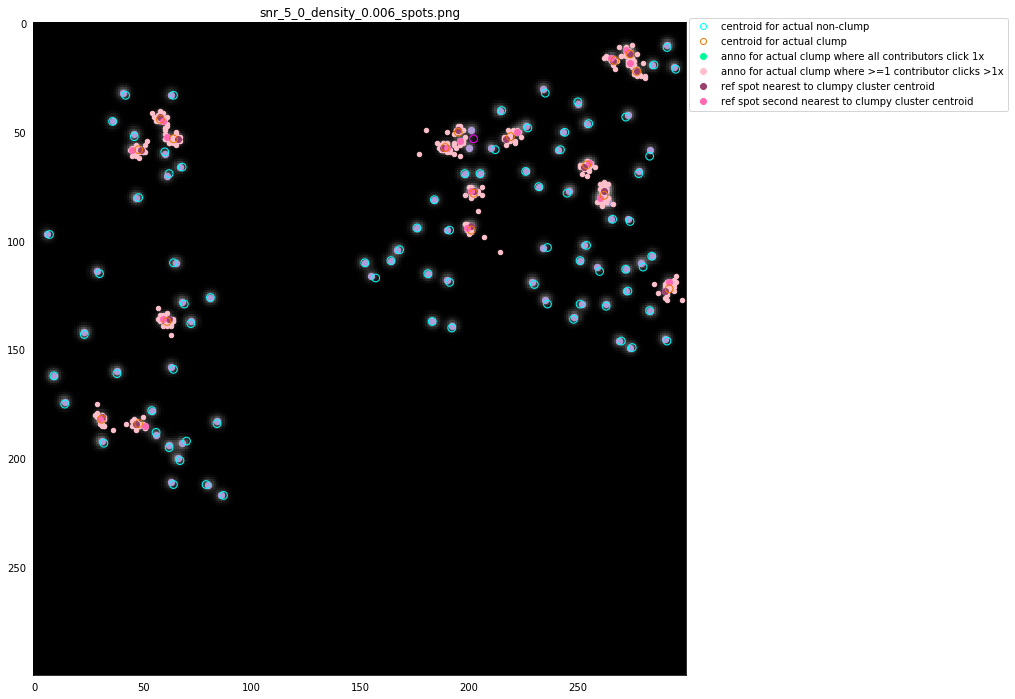

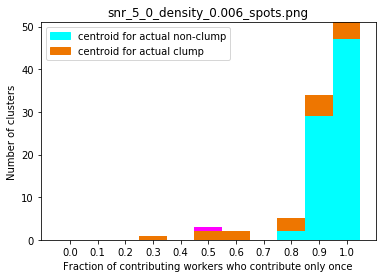

17 actual clumps
78 actual non-clumps


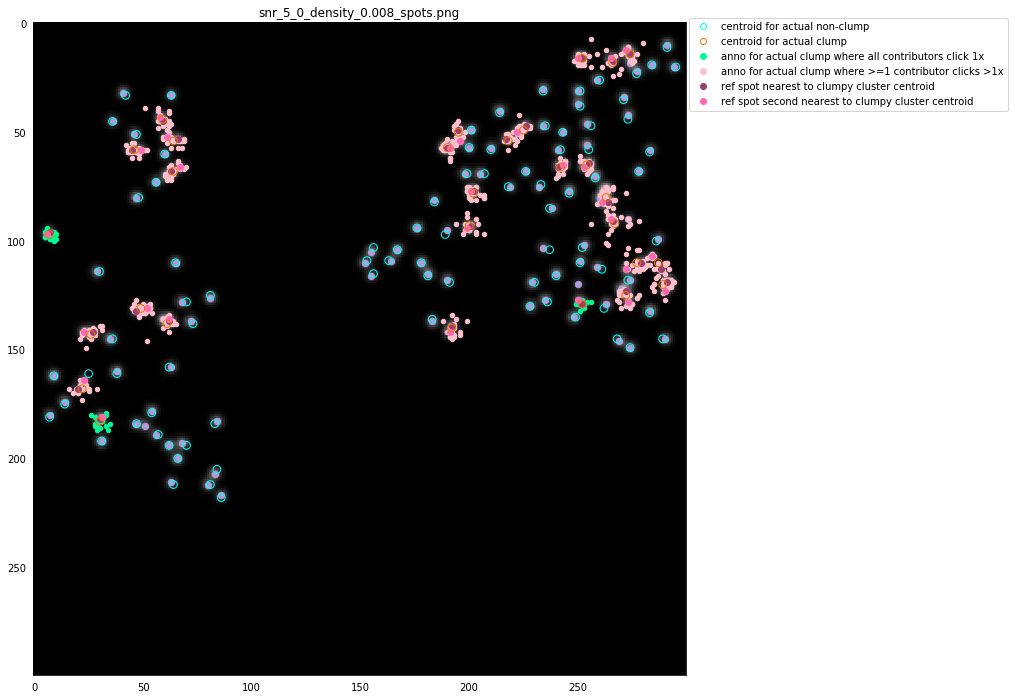

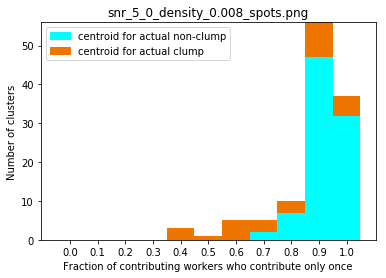

29 actual clumps
88 actual non-clumps


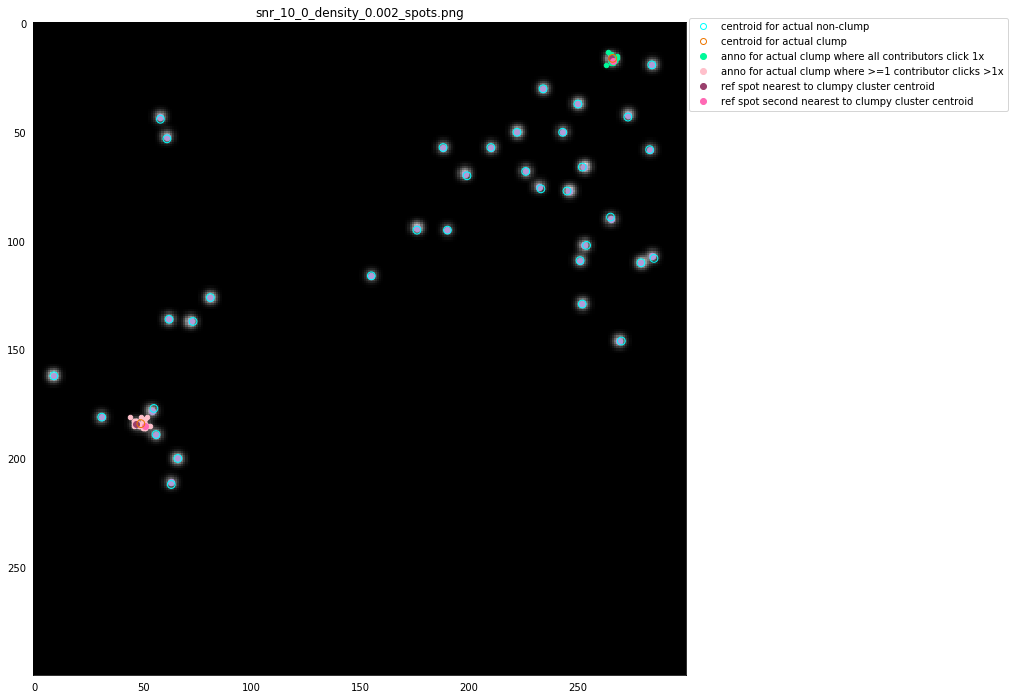

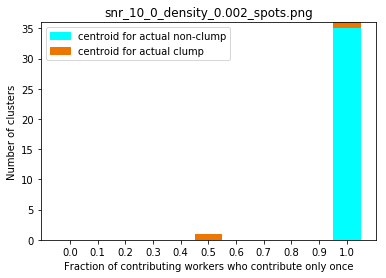

2 actual clumps
35 actual non-clumps


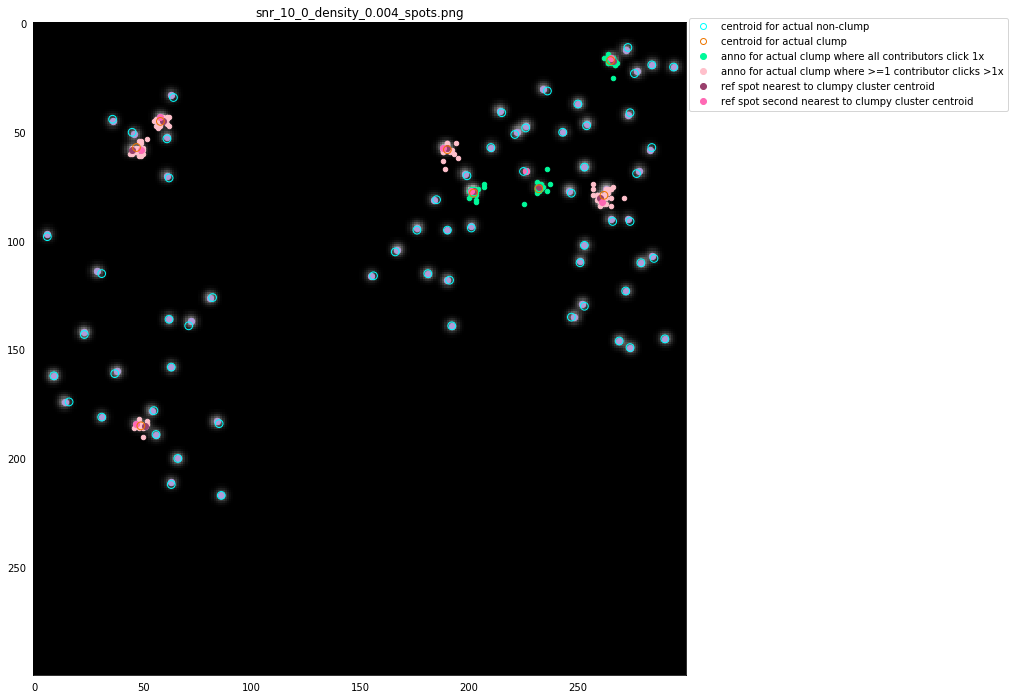

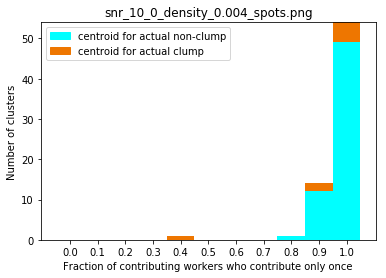

8 actual clumps
62 actual non-clumps


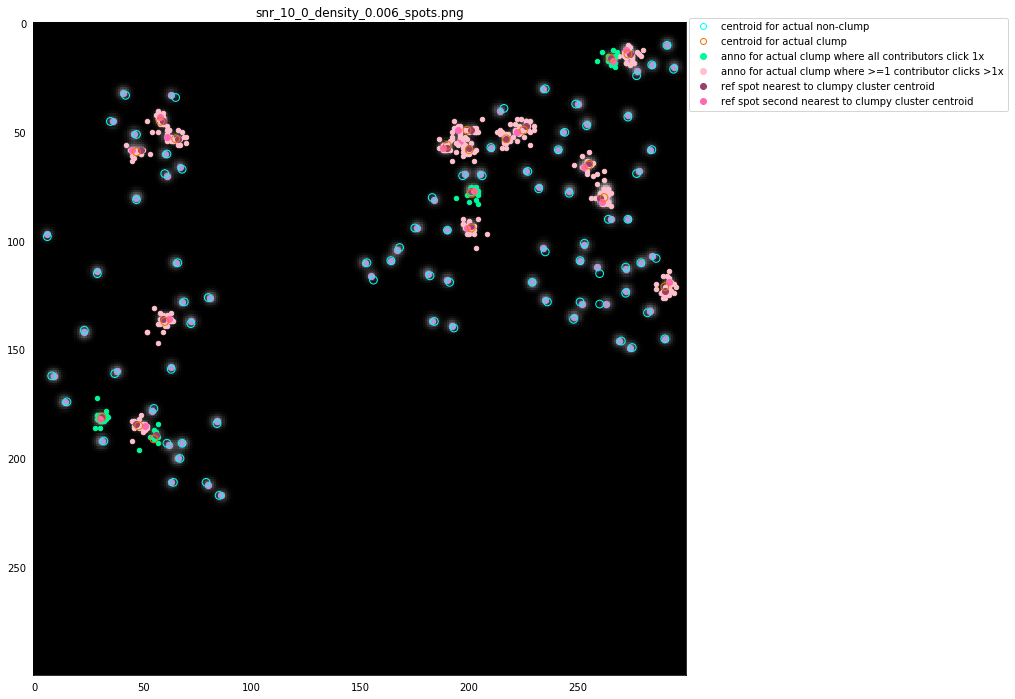

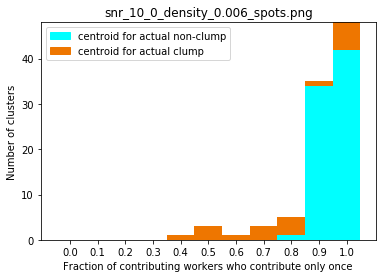

19 actual clumps
77 actual non-clumps


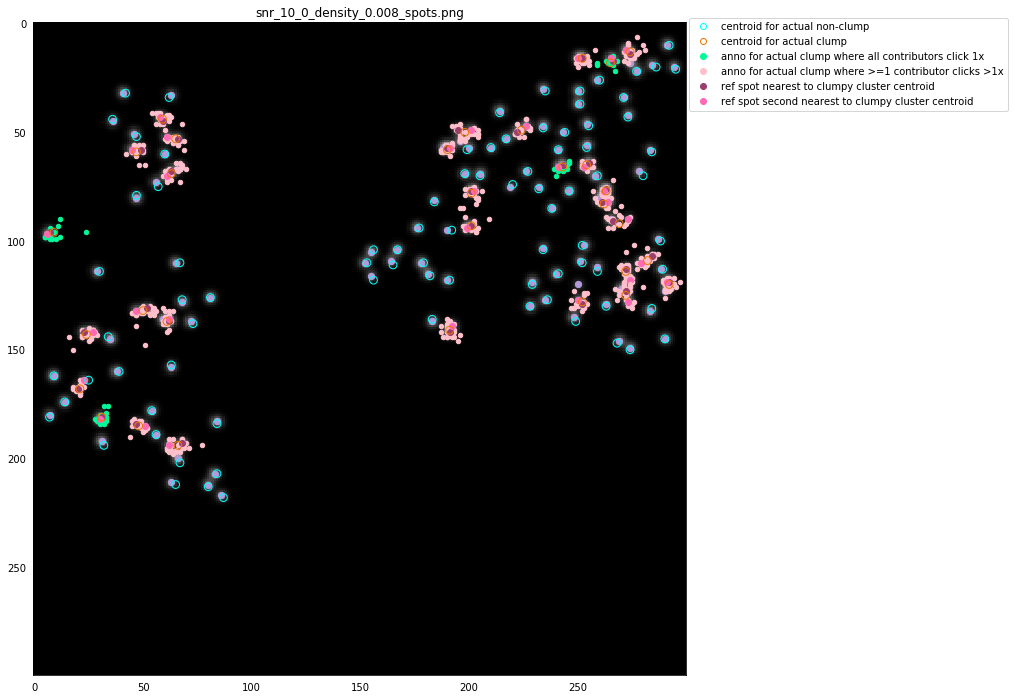

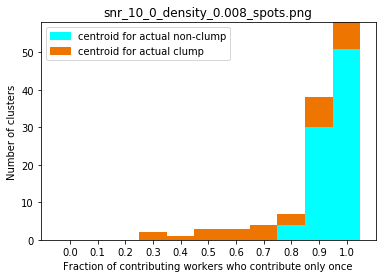

31 actual clumps
85 actual non-clumps


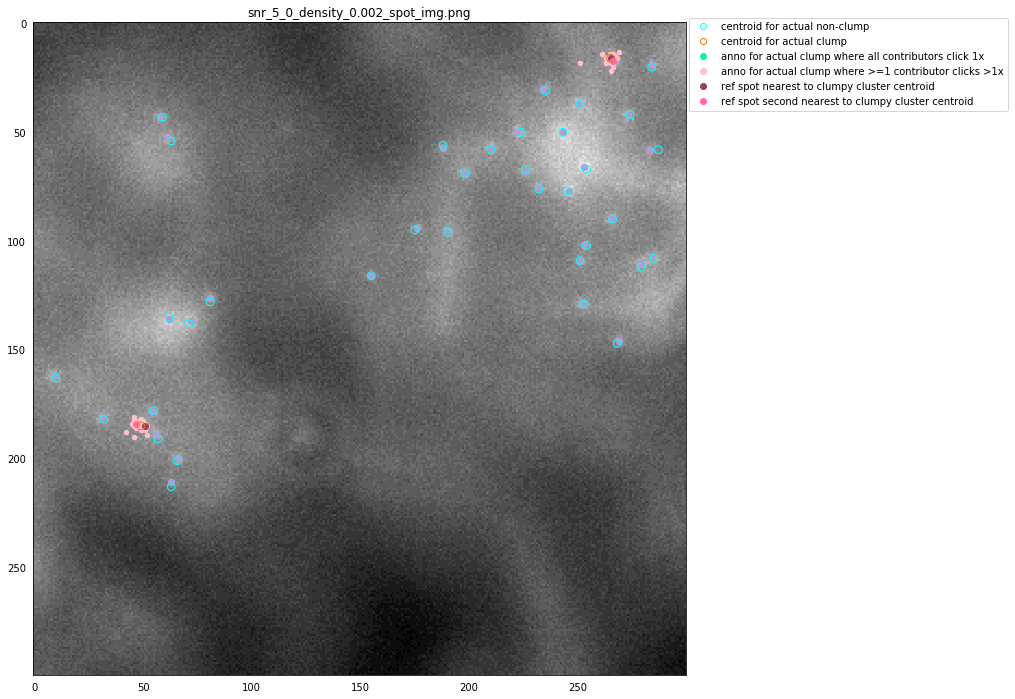

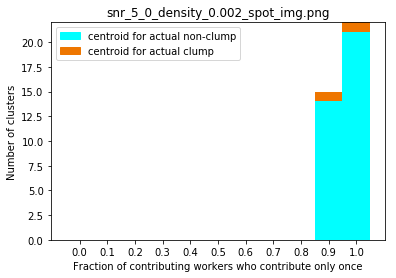

2 actual clumps
35 actual non-clumps


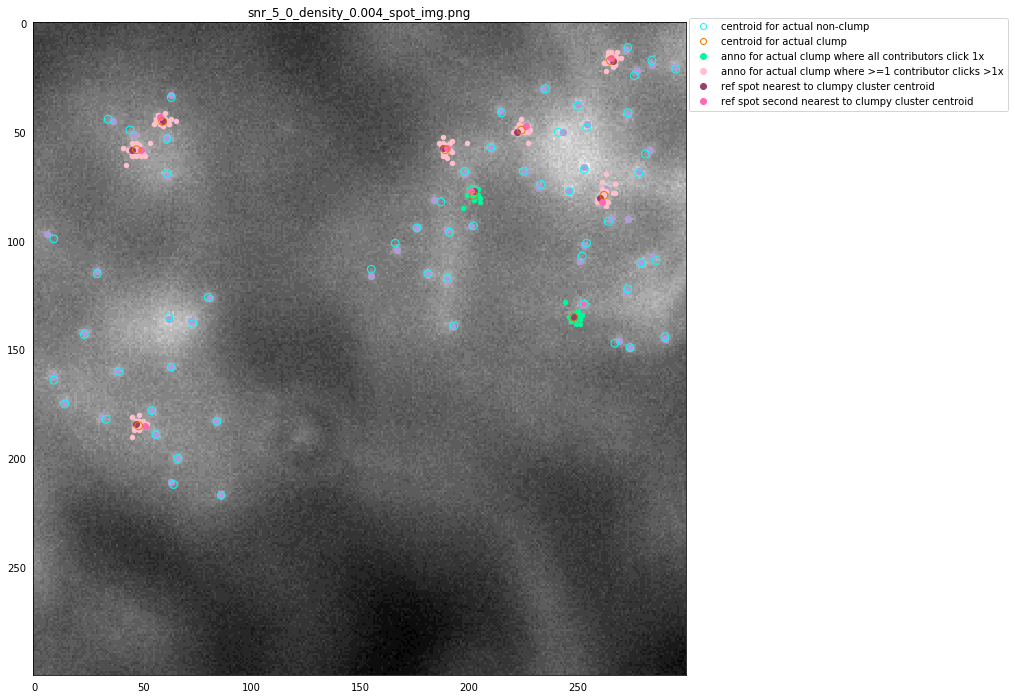

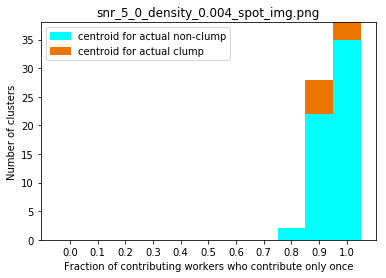

9 actual clumps
59 actual non-clumps


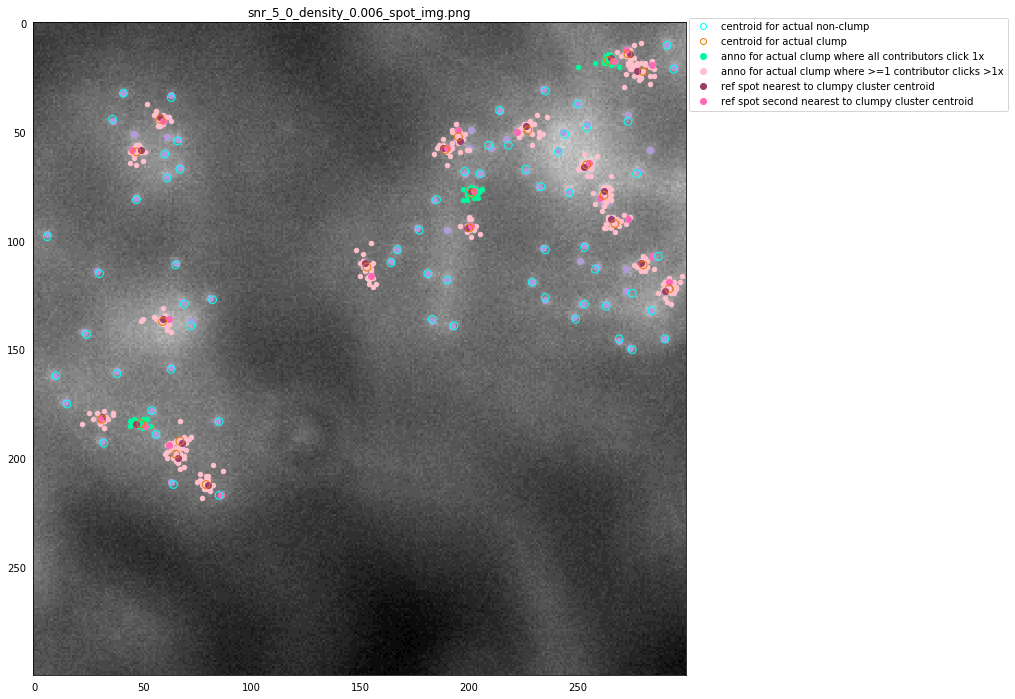

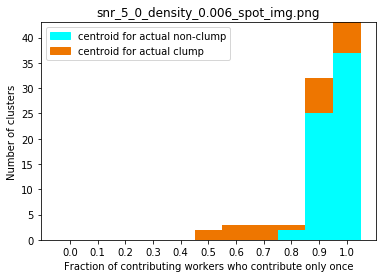

22 actual clumps
64 actual non-clumps


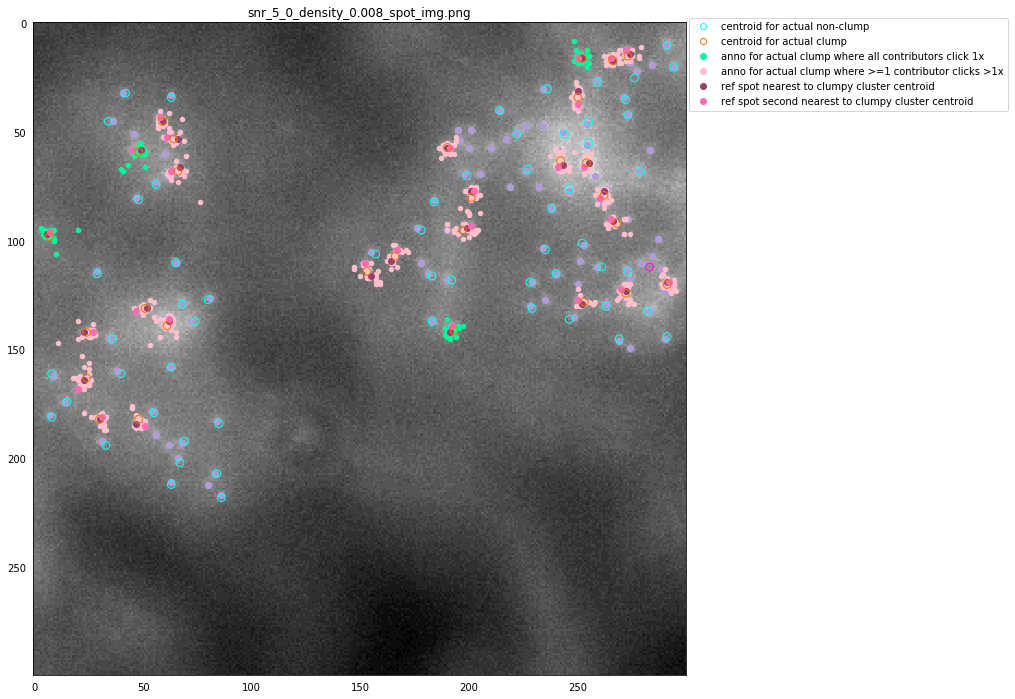

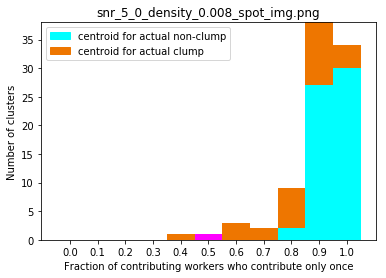

28 actual clumps
59 actual non-clumps


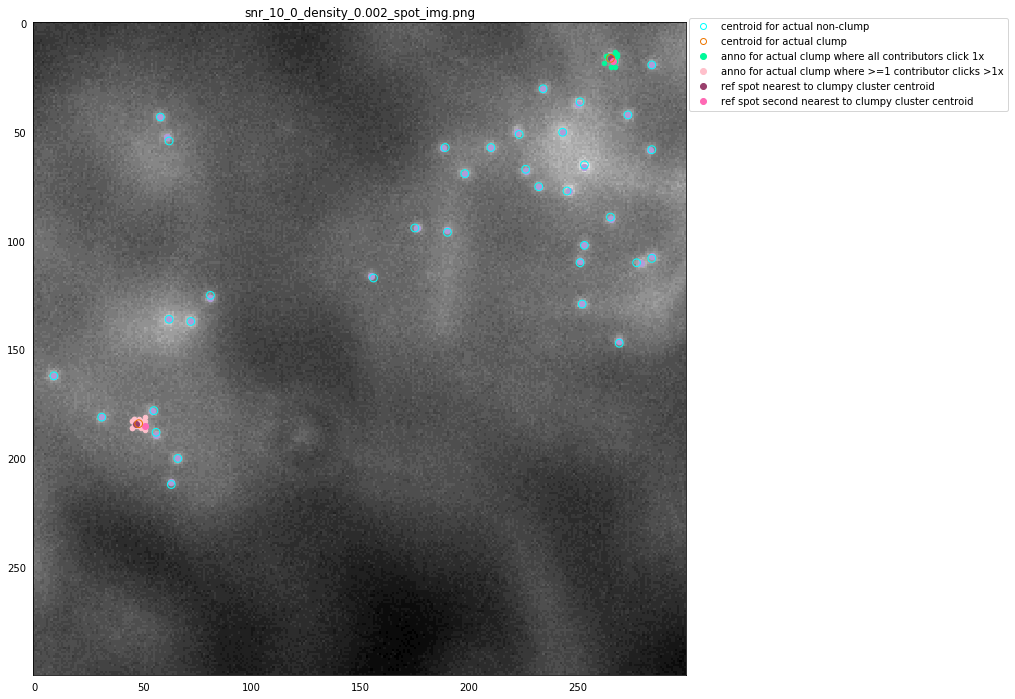

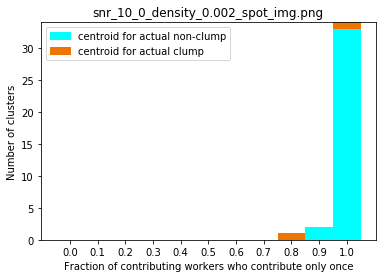

2 actual clumps
35 actual non-clumps


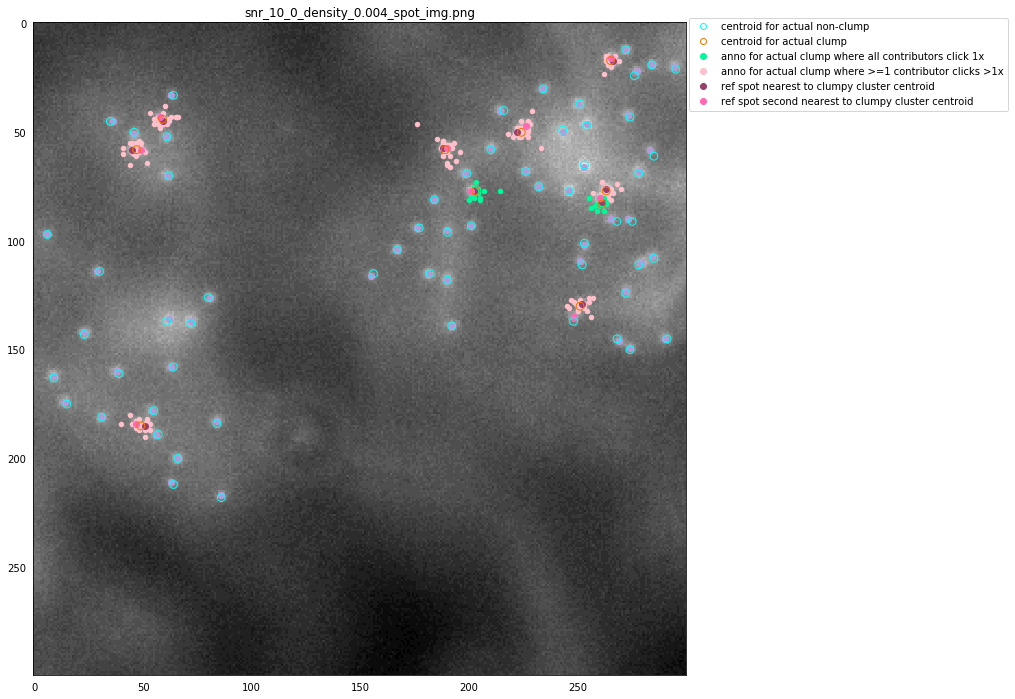

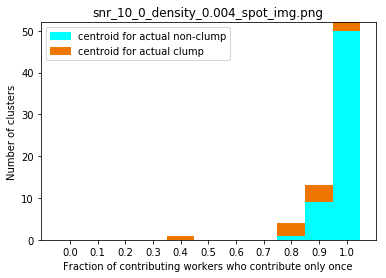

10 actual clumps
60 actual non-clumps


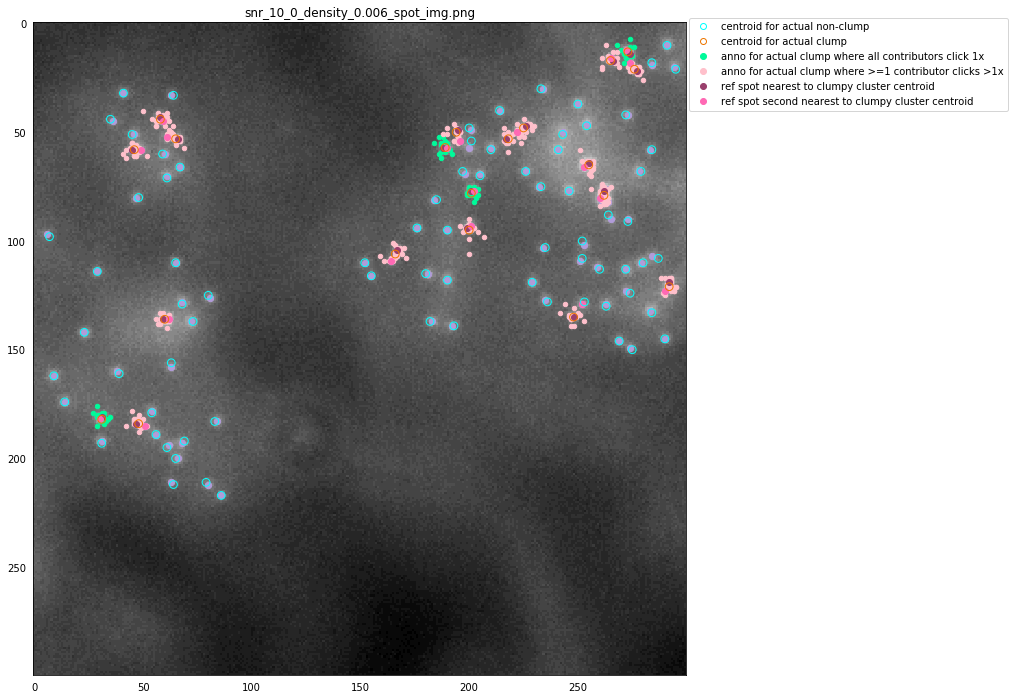

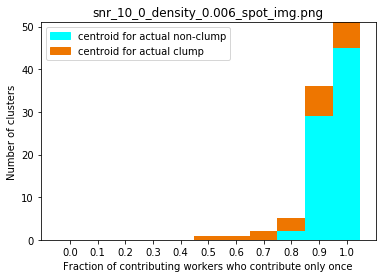

20 actual clumps
76 actual non-clumps


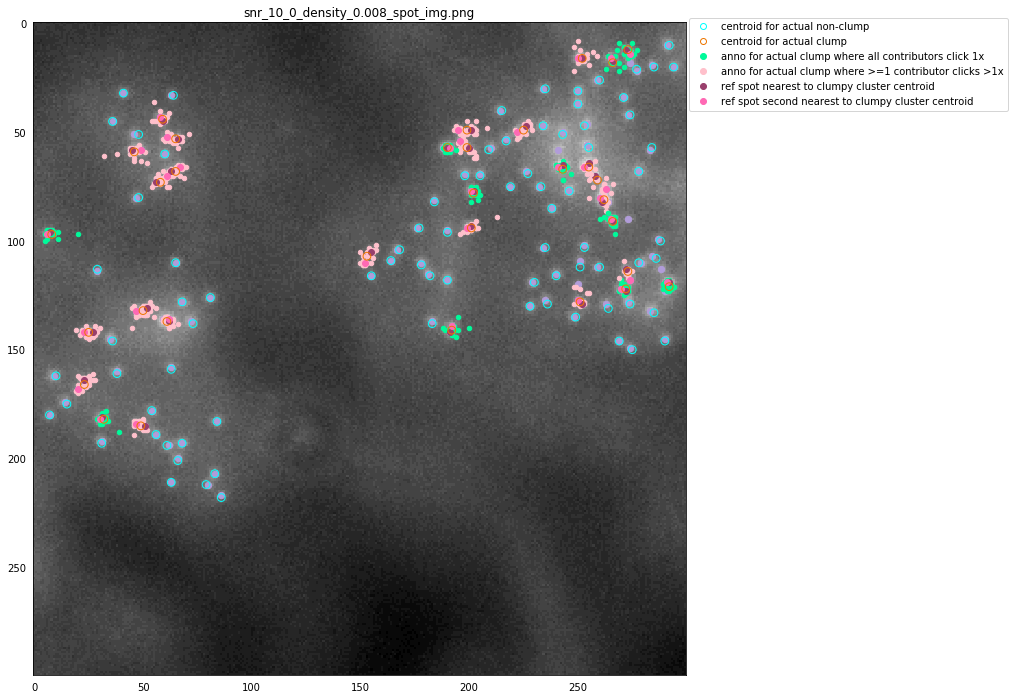

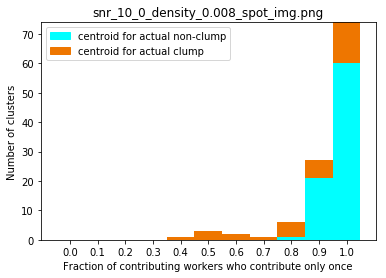

32 actual clumps
82 actual non-clumps


In [2]:
json_filename_list = ['Spots_density_no_tissue.json','Spot_density.json']
density_list = [0.002, 0.004, 0.006, 0.008]
snr_mu_list = [5, 10]
# json_filename_list = ['Spots_density_no_tissue.json']
# density_list = [0.002]
# snr_mu_list = [5]

TPR_list_no_tissue = []
FPR_list_no_tissue = []
TPR_list_with_tissue = []
FPR_list_with_tissue = []
for json_filename in json_filename_list:
    for snr_mu in snr_mu_list:
        for density in density_list:
            img_name = 'snr_' + str(snr_mu)+ '_0_density_' + str(density)
            if (json_filename == 'Spots_density_no_tissue.json'):
                img_filename = img_name+'_spots.png'
                img_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/spot_arrays/'+img_filename
            else:
                img_filename = img_name+'_spot_img.png'
                img_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/spot_images/'+img_filename
            csv_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/spot_data/'+img_name+'_coord_snr_list.csv'
            json_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/'+json_filename

            ba = QuantiusAnnotation(json_filepath)
            sa = SpotAnnotationAnalysis(ba)
            anno_all = ba.df()
            anno_one_image = ba.slice_by_image(anno_all, img_filename)
            ref_kdt = sa.csv_to_kdt(csv_filepath, img_height)
            ref_array = np.asarray(ref_kdt.data)

            # Get large clusters
            clusters = sa.get_clusters(anno_one_image, clustering_params)
            total_num_clusters = len(clusters.index)
            threshold = sa.get_cluster_size_threshold(clusters)
            threshold = math.ceil(threshold)
            small_clusters, large_clusters = sa.sort_clusters_by_size_input_threshold(clusters, threshold)
            
            # For each cluster, calc and sort replication of each worker
            actual_clumps = []
            not_actual_clumps = []
            incorrect_clusters = []
            actual_clump_centroids = []
            not_actual_clump_centroids = []
            incorrect_centroids = []
            
            fig = plt.figure(figsize=(14,12))
            
            # plot ref points
            ref_df = pd.read_csv(csv_filepath)
            ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()
            for point in ref_points:
                plt.scatter([point[0]], [point[1]], c='#b19cd9', s=40)
            
            for i in range(len(large_clusters.index)):
                row = large_clusters.iloc[[i]]
                members = row.iloc[0]['members']
                workers = []
                x_coords = []
                y_coords = []
                for member in members:
                    x_coords.append(member[0])
                    y_coords.append(member[1])
                    workers.append(member[3])
                    
                # Calculate replication of unique workers for each cluster
                unique_workers = np.unique(workers)
                num_instances_list = []
                for unique_worker in unique_workers:
                    num_instances_list.append(workers.count(unique_worker))
                singles = num_instances_list.count(1)
                single_fraction = singles/len(unique_workers)
    
                # Are there at least two ref spots in the area of this cluster? (Is this cluster actually clumpy?)  
                centroid_coord = [row.iloc[0]['centroid_x'], row.iloc[0]['centroid_y']]
                dist, ind = ref_kdt.query([centroid_coord],k=2)
                index_0 = ind[0][0]
                index_1 = ind[0][1]
                neighbor_0 = ref_array[index_0]
                neighbor_1 = ref_array[index_1]
                if(dist[0][0] <= 4):
                    if ((neighbor_0[0] >= min(x_coords)) and (neighbor_0[0] <= max(x_coords)) and
                        (neighbor_0[1] >= min(y_coords)) and (neighbor_0[1] <= max(y_coords)) and 
                        (neighbor_1[0] >= min(x_coords)) and (neighbor_1[0] <= max(x_coords)) and
                        (neighbor_1[1] >= min(y_coords)) and (neighbor_1[1] <= max(y_coords))):
                        cluster_is_clumpy = True
                        if(single_fraction == 1):
                            color = '#00fa9a'
                        else:
                            color = '#ffC0cb'
                        plt.scatter(x_coords, ba.flip(y_coords, img_height), c=color, s=20)
                        plt.scatter([neighbor_0[0]], [img_height-neighbor_0[1]], c='#993f6c')
                        plt.scatter([neighbor_1[0]], [img_height-neighbor_1[1]], c='#ff69b4')

                    else:
                        cluster_is_clumpy = False
                    if cluster_is_clumpy:
                        actual_clumps.append(single_fraction)
                        actual_clump_centroids.append(centroid_coord)
                    else:
                        not_actual_clumps.append(single_fraction)
                        not_actual_clump_centroids.append(centroid_coord)
                else:
                    incorrect_clusters.append(single_fraction)
                    incorrect_centroids.append(centroid_coord)
                    
            # calc k-means threshold
            total_list = not_actual_clumps + actual_clumps + incorrect_clusters
            total_array = np.asarray(total_list)
            km = KMeans(n_clusters = 2).fit(total_array.reshape(-1,1))
            cluster_centers = km.cluster_centers_
            threshold_kmeans = (cluster_centers[0][0]+cluster_centers[1][0])/2
            
            # calc otsu threshold
            threshold_otsu = filters.threshold_otsu(np.asarray(total_list))

            # plot centroids
            actual_clump_centroids = np.asarray(actual_clump_centroids)
            not_actual_clump_centroids = np.asarray(not_actual_clump_centroids)
            incorrect_centroids = np.asarray(incorrect_centroids)
            plt.scatter(not_actual_clump_centroids[:,0], ba.flip(not_actual_clump_centroids[:,1], img_height), facecolors = 'None', edgecolors ='#00ffff', s=60)
            plt.scatter(actual_clump_centroids[:,0], ba.flip(actual_clump_centroids[:,1], img_height), facecolors = 'None', edgecolors ='#ee7600', s=60)
            if (incorrect_centroids.size > 0):
                plt.scatter(incorrect_centroids[:,0], ba.flip(incorrect_centroids[:,1], img_height), facecolors = 'None', edgecolors ='magenta', s=60)
                
            # plot image
            img = mpimg.imread(img_filepath)
            plt.tick_params(
                axis='both',
                which='both',
                bottom=False,
                top=False,
                left=False,
                right=False)
            plt.imshow(img, cmap = 'gray')
            
            # legend elements
            leg_elem_1 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='#00ffff', markerfacecolor='None', label='centroid for actual non-clump')
            leg_elem_2 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='#ee7600', markerfacecolor='None', label='centroid for actual clump')
            leg_elem_3 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='#00fa9a', markerfacecolor='#00fa9a', label='anno for actual clump where all contributors click 1x')
            leg_elem_4 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='#ffC0cb', markerfacecolor='#ffC0cb', label='anno for actual clump where >=1 contributor clicks >1x')
            leg_elem_5 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='#993f6c', markerfacecolor='#993f6c', label='ref spot nearest to clumpy cluster centroid')
            leg_elem_6 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='#ff69b4', markerfacecolor='#ff69b4', label='ref spot second nearest to clumpy cluster centroid')
            handle_list = [leg_elem_1, leg_elem_2, leg_elem_3, leg_elem_4, leg_elem_5, leg_elem_6]
            plt.legend(handles = handle_list, loc = 9, bbox_to_anchor = (1.25, 1.015))
            
            plt.title(img_filename)
            plt.show()
            
            # plot single fraction histograms
            fig = plt.figure()
            plt.hist([not_actual_clumps, actual_clumps, incorrect_clusters], stacked = True, color = ['#00ffff', '#ee7600', 'magenta'], bins = np.arange(0,1.2,0.1)-0.05)
            
            plt.xlabel('Fraction of contributing workers who contribute only once')
            plt.ylabel('Number of clusters')
            plt.xticks(np.arange(0,1.1, 0.1))
            
            blue_patch = mpatches.Patch(color='#00ffff', label='centroid for actual non-clump')
            orange_patch = mpatches.Patch(color='#ee7600', label='centroid for actual clump')
            kmeans_line = Line2D([0],[0], color='b', label='k-means threshold')
            otsu_line = Line2D([0],[0], color='r', label='otsu threshold')
            
            plt.legend(handles=[blue_patch, orange_patch])
#             plt.legend(handles=[blue_patch, orange_patch, kmeans_line, otsu_line])
#             plt.axvline(x=threshold_kmeans, color='blue')
#             plt.axvline(x=threshold_otsu, color='red')
            
            plt.title(img_filename)
            plt.show()
            print(str(len(actual_clumps)) + ' actual clumps')
            print(str(len(not_actual_clumps)) + ' actual non-clumps')
            
            